[![Open In Colab](https://colab.research.google.com/assets/colab-badge.svg)](https://colab.research.google.com/drive/1kxkUyRjSsNNq5GNV1ujHMbjA7Sbccq_3?usp=sharing)

In [ ]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


In [ ]:
# !pip install torch torchvision torchaudio -U
# !pip install tqdm numpy -U

**Overview of what we will be doing at each step:**


---


1. **Loading and preprocessing the data**: We will load the dataset and preprocess it to get it ready for training and testing.

2. **Splitting the data into train and test sets**: We will split the dataset into two parts, one for training and one for testing.

3. **Fine-tuning BERT**: We will fine-tune the pre-trained BERT model on our dataset, so that it can learn to classify text as either positive or negative.

4. **Evaluating the model**: We will evaluate the performance of our model on the test set to see how well it is able to classify text.

**Step 1: Loading and Preprocessing the Data**

In [ ]:
!pip install transformers

Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 7.0/7.0 MB 46.3 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 200.1/200.1 kB 26.5 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 7.8/7.8 MB 75.1 MB/s eta 0:00:00


In [ ]:

import pandas as pd
import numpy as np
import torch
import transformers
from transformers import AdamW

from nltk.corpus import stopwords
import re
import string
import nltk

import seaborn as sns
import matplotlib.pyplot as plt
from sklearn.metrics import confusion_matrix
import itertools

pd.set_option('display.max_colwidth', None)
import warnings
warnings.filterwarnings("ignore")
import tensorflow as tf

In [ ]:
print("pandas:", pd.__version__)
print("numpy:", np.__version__)
print("torch:", torch.__version__)
print("transformers:", transformers.__version__)
print("nltk:", nltk.__version__)
print("seaborn:", sns.__version__)
print("matplotlib:", plt.__version__)
print("sklearn:", confusion_matrix.__version__)
print("tensorflow:", tf.__version__)

In [ ]:
# %load_ext tensorboard

from torch.utils.tensorboard import SummaryWriter
writer = SummaryWriter()

In [ ]:
# from torch.utils.tensorboard import SummaryWriter

# writer = SummaryWriter('logs')

Temporary use this dataset: [tweets_combined.csv](https://github.com/swcwang/depression-detection/blob/master/data/tweets_combined.csv).

In [ ]:
df = pd.read_csv('/content/drive/My Drive/Colab Notebooks/Twitter/tweets_combined.csv', skiprows=[0], names=['label', 'text'])

In [ ]:
df.head()

,label,text
0,1,Today in Selfcare: beauty &amp; laughs Kung Fu Panda 3 #Wellness #joy #laughter #selfcare #therapist #philadelphia
1,0,I get to spend New Year's home again alone and lonely. ???•
2,0,"Depressed and lonely /: Stuck in a deep, never ending hole :("
3,1,"If this is your response to someone saying they're dealing with , you're a terrible person."
4,1,Apparently you get a free pass just by mentioning Where was I on the free badge day??!!


In [ ]:
df.shape

(3200, 2)

We will now preprocess the data to remove any unwanted characters, punctuation marks, and stopwords, and tokenize the data:

In [ ]:
nltk.download('stopwords')
stop_words = stopwords.words('english')
def preprocess_text(text):
    text = text.lower()
    text = re.sub(r'\d+', '', text)
    text = text.translate(str.maketrans('', '', string.punctuation))
    text = ' '.join([word for word in text.split() if word not in stop_words])
    return text

df['text'] = df['text'].apply(preprocess_text)

tokenizer = transformers.AutoTokenizer.from_pretrained('bert-base-uncased')

tokenized = df['text'].apply((lambda x: tokenizer.encode(x, add_special_tokens=True)))

max_len = 0
for i in tokenized.values:
    if len(i) > max_len:
        max_len = len(i)

padded = np.array([i + [0]*(max_len-len(i)) for i in tokenized.values])

[nltk_data] Downloading package stopwords to /root/nltk_data...
[nltk_data]   Unzipping corpora/stopwords.zip.


**Step 2: Splitting the Data into Train and Test Sets**

Next, we will split the dataset into two parts, one for training the model and the other for testing the model's performance.

In [ ]:
from sklearn.model_selection import train_test_split

labels = df['label']

# Split the dataset into train and test sets
input_ids_train, input_ids_test, labels_train, labels_test = train_test_split(padded, labels, random_state=42, test_size=0.2)


**Step 3: Fine-Tuning BERT**

In [ ]:
model = transformers.BertForSequenceClassification.from_pretrained('bert-base-uncased', num_labels=2, return_dict=False)

Some weights of the model checkpoint at bert-base-uncased were not used when initializing BertForSequenceClassification: ['cls.predictions.transform.LayerNorm.bias', 'cls.seq_relationship.weight', 'cls.predictions.transform.dense.bias', 'cls.predictions.transform.LayerNorm.weight', 'cls.predictions.decoder.weight', 'cls.predictions.bias', 'cls.seq_relationship.bias', 'cls.predictions.transform.dense.weight']
- This IS expected if you are initializing BertForSequenceClassification from the checkpoint of a model trained on another task or with another architecture (e.g. initializing a BertForSequenceClassification model from a BertForPreTraining model).
- This IS NOT expected if you are initializing BertForSequenceClassification from the checkpoint of a model that you expect to be exactly identical (initializing a BertForSequenceClassification model from a BertForSequenceClassification model).
Some weights of BertForSequenceClassification were not initialized from the model checkpoint at

In [ ]:
import logging
logging.getLogger("transformers.modeling_utils").setLevel(logging.ERROR)


# print(model.bert.embeddings)

# Print the activation function used in the model
print('Activation Function: ', model.config.hidden_act)


num_hidden_layers = model.bert.config.num_hidden_layers
print('Number of Layers:', num_hidden_layers)


# Get the embedding size
embedding_size = model.bert.embeddings.word_embeddings.embedding_dim
print(f"Embedding size: {embedding_size}")

# Get the dropout value
dropout = model.bert.embeddings.dropout.p
print(f"Dropout value: {dropout}")



Activation Function:  gelu
Number of Layers: 12
Embedding size: 768
Dropout value: 0.1


In [ ]:
# print(model)

Since this is a small sample from the dataset, and to avoid convergence, I will select batch size between 32-64, this may change it again after evaluating the model.

In [ ]:
batch_size = 64

# Create the DataLoader for training set
train_data = torch.utils.data.TensorDataset(torch.tensor(input_ids_train), torch.tensor(labels_train.values))
train_sampler = torch.utils.data.RandomSampler(train_data)
train_dataloader = torch.utils.data.DataLoader(train_data, sampler=train_sampler, batch_size=batch_size)


In [ ]:
# import transformers

optimizer = torch.optim.Adam(model.parameters(), lr=2e-5)

epochs = 4
# total_steps = len(train_dataloader) * epochs

# scheduler = transformers.get_linear_schedule_with_warmup(optimizer, 
#                                                          num_warmup_steps = 0,
#                                                          num_training_steps = total_steps)


We will now train the model:



In [ ]:
def accuracy(logits, labels):
    preds = torch.argmax(logits, dim=1).flatten()
    correct = (preds == labels).sum()
    accuracy = correct.item() / len(labels)
    return accuracy

In [ ]:
%load_ext tensorboard

In [ ]:
# tensorboard --logdir==./

In [ ]:
# tensorboard_callback = tf.keras.callbacks.TensorBoard(logdir, histogram_freq=1)

In [ ]:
import random

# Set the seed value
seed_val = 42

# Set up GPU/CPU device
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")

# Set the random seed for reproducibility
random.seed(seed_val)
np.random.seed(seed_val)
torch.manual_seed(seed_val)
torch.cuda.manual_seed_all(seed_val)

# Train the model
model.to(device)

optimizer = AdamW(model.parameters(),
                  lr = 2e-5, # args.learning_rate - default is 5e-5
                  eps = 1e-8 # args.adam_epsilon  - default is 1e-8
                )

total_steps = len(train_dataloader) * epochs

scheduler = transformers.get_linear_schedule_with_warmup(optimizer, 
                                            num_warmup_steps = 0, 
                                            num_training_steps = total_steps)

# writer = SummaryWriter(log_dir=log_dir)
global_step = 0

for epoch in range(epochs):
    print('======== Epoch {:} / {:} ========'.format(epoch + 1, epochs))
    total_train_loss = 0
    model.train()
    for step, batch in enumerate(train_dataloader):
        batch_input_ids = batch[0].to(device)
        batch_labels = batch[1].to(device)

        model.zero_grad()        

        loss, logits = model(batch_input_ids, 
                             token_type_ids=None, 
                             attention_mask=(batch_input_ids > 0), 
                             labels=batch_labels)
        
        total_train_loss += loss.item()
        
        loss.backward()

        torch.nn.utils.clip_grad_norm_(model.parameters(), 1.0)

        optimizer.step()

        scheduler.step()
        
        print("Batch {:>5,} Loss: {:.4f}".format(step, loss.item()))

        # Write training loss and accuracy to TensorBoard
        writer.add_scalar('Training Loss', loss.item(), global_step)
        writer.add_scalar('Training Accuracy', accuracy(logits, batch_labels), global_step)

        writer.add_scalar('Training Loss', loss.item(), epoch)
        writer.add_scalar('Training Accuracy', accuracy(logits, batch_labels), epoch)




        global_step += 1
        
    avg_train_loss = total_train_loss / len(train_dataloader)
    writer.flush()



======== Epoch 1 / 4 ========
Batch     0 Loss: 0.7016
Batch     1 Loss: 0.6575
Batch     2 Loss: 0.5970
Batch     3 Loss: 0.5683
Batch     4 Loss: 0.5444
Batch     5 Loss: 0.5783
Batch     6 Loss: 0.6083
Batch     7 Loss: 0.4990
Batch     8 Loss: 0.6418
Batch     9 Loss: 0.5841
Batch    10 Loss: 0.6773
Batch    11 Loss: 0.5941
Batch    12 Loss: 0.6044
Batch    13 Loss: 0.6154
Batch    14 Loss: 0.5295
Batch    15 Loss: 0.5000
Batch    16 Loss: 0.5140
Batch    17 Loss: 0.5294
Batch    18 Loss: 0.5796
Batch    19 Loss: 0.5699
Batch    20 Loss: 0.5553
Batch    21 Loss: 0.5527
Batch    22 Loss: 0.4556
Batch    23 Loss: 0.6200
Batch    24 Loss: 0.5180
Batch    25 Loss: 0.4977
Batch    26 Loss: 0.5069
Batch    27 Loss: 0.4360
Batch    28 Loss: 0.4609
Batch    29 Loss: 0.4754
Batch    30 Loss: 0.4254
Batch    31 Loss: 0.4215
Batch    32 Loss: 0.4638
Batch    33 Loss: 0.5510
Batch    34 Loss: 0.5257
Batch    35 Loss: 0.4261
Batch    36 Loss: 0.4250
Batch    37 Loss: 0.4106
Batch    38 Loss: 0.

In [ ]:
avg_train_loss = total_train_loss / len(train_dataloader)            
print("Average training loss: {0:.2f}".format(avg_train_loss))

Average training loss: 0.28


We will now evaluate the model on the testing set:

In [ ]:
def flat_accuracy(preds, labels):
    """
    Calculate the accuracy of the predicted values compared to the true labels.
    """
    pred_flat = np.argmax(preds, axis=1).flatten()
    labels_flat = labels.flatten()
    return np.sum(pred_flat == labels_flat) / len(labels_flat)


In [ ]:
# ... code to evaluate the model ...

# Create the DataLoader for test set
test_data = torch.utils.data.TensorDataset(torch.tensor(input_ids_test), torch.tensor(labels_test.values))
test_sampler = torch.utils.data.SequentialSampler(test_data)
test_dataloader = torch.utils.data.DataLoader(test_data, sampler=test_sampler, batch_size=batch_size)

# Evaluate the model on the test set
model.eval()

total_eval_accuracy = 0
total_eval_loss = 0
nb_eval_steps = 0
predictions, true_labels = [], []

for batch in test_dataloader:
    batch_input_ids = batch[0].to(device)
    batch_labels = batch[1].to(device)

    with torch.no_grad():        

        (loss, logits) = model(batch_input_ids, 
                               token_type_ids=None, 
                               attention_mask=(batch_input_ids > 0),
                               labels=batch_labels)
                
    total_eval_loss += loss.item()

    logits = logits.detach().cpu().numpy()
    label_ids = batch_labels.to('cpu').numpy()
    total_eval_accuracy += flat_accuracy(logits, label_ids)
    predictions.extend(np.argmax(logits, axis=1))
    true_labels.extend(label_ids)

    # Monitor testing accuracy and loss
    writer.add_scalar('Testing Loss', loss.item(), nb_eval_steps)
    writer.add_scalar('Testing Accuracy', flat_accuracy(logits, label_ids), nb_eval_steps)

    nb_eval_steps += 1

# Calculate the average accuracy and loss over all of the batches.
avg_val_accuracy = total_eval_accuracy / len(test_dataloader)
avg_val_loss = total_eval_loss / len(test_dataloader)

# Write the average accuracy and loss to the Tensorboard log.
writer.add_scalar('Testing Loss', avg_val_loss, global_step)
writer.add_scalar('Testing Accuracy', avg_val_accuracy, global_step)

# Report the final accuracy for this test run.
avg_val_accuracy = total_eval_accuracy / len(test_dataloader)
print("Accuracy: {0:.2f}".format(avg_val_accuracy))

# Calculate the average loss over all of the batches
avg_val_loss = total_eval_loss / len(test_dataloader)
print("Validation Loss: {0:.2f}".format(avg_val_loss))

Accuracy: 0.80
Validation Loss: 0.45


In [ ]:
# %tensorboard --logdir logs

              precision    recall  f1-score
0              0.567708  0.698718  0.626437
1              0.895089  0.828512  0.860515
accuracy       0.796875  0.796875  0.796875
macro avg      0.731399  0.763615  0.743476
weighted avg   0.815290  0.796875  0.803458


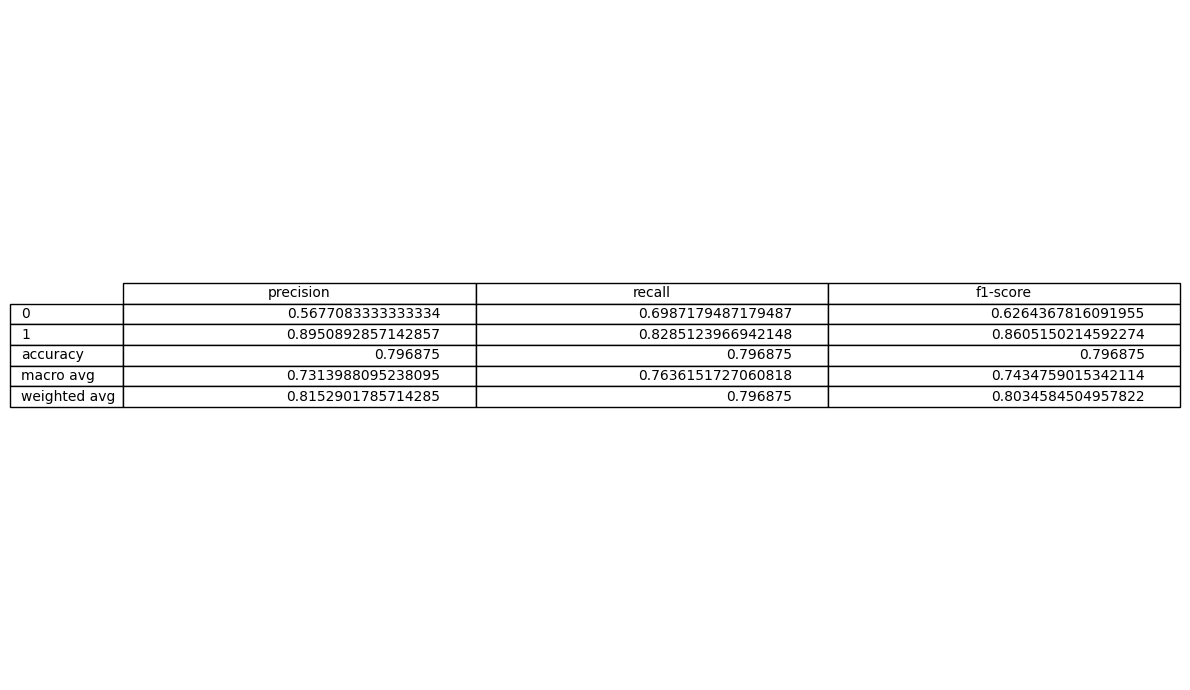

In [ ]:

import pandas as pd
from sklearn.metrics import classification_report


def classification_report_without_support(true_labels, predictions):
    report = classification_report(true_labels, predictions, output_dict=True)
    df = pd.DataFrame(report).transpose()
    df.drop('support', axis=1, inplace=True)
    return df


# Compute evaluation metrics
df = classification_report_without_support(true_labels, predictions)


# Define styles for the table
styles = [
    dict(selector='th', props=[('text-align', 'center'), ('font-weight', 'bold')]),
    dict(selector='caption', props=[('caption-side', 'bottom')])
]

# Set the format of the values in the DataFrame
format_dict = {'precision': '{:.2f}', 'recall': '{:.2f}', 'f1-score': '{:.2f}'}
# df = df.style.format(format_dict).set_table_styles(styles)
df = df.style.format(format_dict, na_rep='').set_table_styles(styles)


# # Convert the Styler object back to a DataFrame
df = df.data

# df.index.names = [None] * (len(df.index.names) - 1) + ['Class']
# df.columns.names = ['Metric']

# Print the table
print(df)

# Save the table as a PNG file
import matplotlib.pyplot as plt

fig, ax = plt.subplots(figsize=(12, 7))
ax.axis('off')
ax.axis('tight')
ax.table(cellText=df.values, rowLabels = df.index, colLabels=df.columns, loc='center')
fig.tight_layout()
plt.savefig('/content/drive/My Drive/Colab Notebooks/Twitter/classification_report.png')


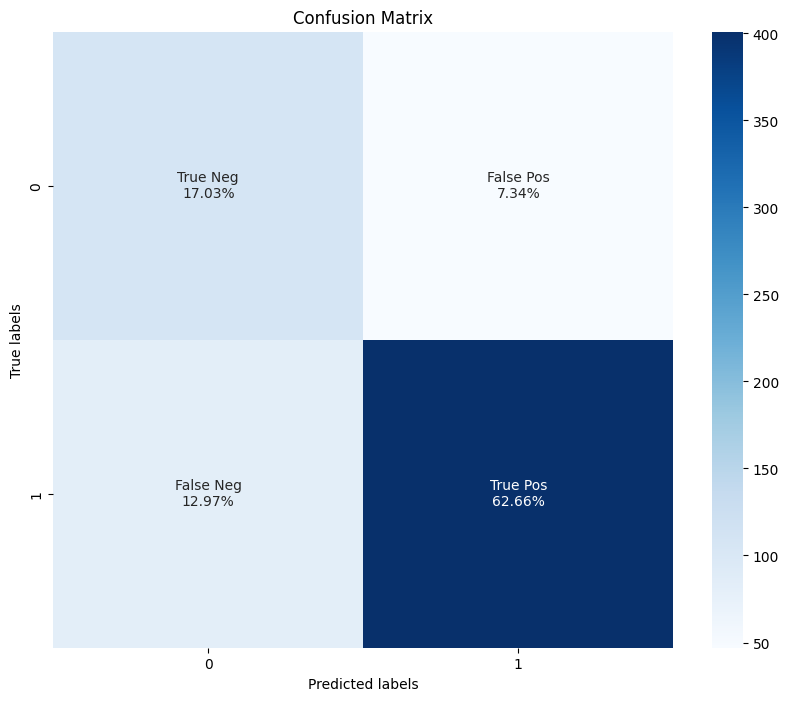

In [ ]:
from sklearn.metrics import confusion_matrix

confusion_matrix = confusion_matrix(true_labels, predictions)


group_names = ['True Neg', 'False Pos','False Neg','True Pos']
group_counts = ["{0:0.0f}".format(value) for value in confusion_matrix.flatten()]
group_percentages = ["{0:.2%}".format(value) for value in confusion_matrix.flatten()/np.sum(confusion_matrix)]
labels = [f"{v1}\n{v2}" for v1, v2 in
          zip(group_names,group_percentages)]
labels = np.asarray(labels).reshape(2,2)

# Plot heatmap
plt.figure(figsize=(10, 8))

heatmap = sns.heatmap(confusion_matrix, annot=labels, fmt='', cmap='Blues')
plt.xlabel('Predicted labels')
plt.ylabel('True labels')
plt.title('Confusion Matrix')
plt.show()


# Save the heatmap as a PNG file
fig = heatmap.get_figure()
fig.tight_layout()
fig.savefig('/content/drive/My Drive/Colab Notebooks/Twitter/confusion_matrix.png')

In [ ]:
len(train_data), len(test_data)

(2560, 640)

**Step 4: Making Predictions**

Finally, we will use the trained model to make predictions on new sentences. 

We will first tokenize the new sentences; using the same tokenizer used for training and testing:

In [ ]:
# Tokenize input sentence
def tokenize_sentence(sentence):
    input_ids = []
    attention_masks = []

    encoded_dict = tokenizer.encode_plus(
                        sentence,                      # Sentence to encode.
                        add_special_tokens = True,     # Add '[CLS]' and '[SEP]'
                        max_length = max_len,          # Pad or truncate all sentences.
                        pad_to_max_length = True,
                        return_attention_mask = True,  # Construct attn. masks.
                        return_tensors = 'pt',         # Return pytorch tensors.
                   )
    
    # Add the encoded sentence to the list.    
    input_ids.append(encoded_dict['input_ids'])
    
    # And its attention mask (simply differentiates padding from non-padding).
    attention_masks.append(encoded_dict['attention_mask'])
    
    return torch.cat(input_ids, dim=0), torch.cat(attention_masks, dim=0)


Then, we pass the tokenized sentence through the trained model to obtain the predicted label:

In [ ]:
# Load sample


# Load your dataframe
df = pd.read_csv('/content/drive/My Drive/Colab Notebooks/Twitter/final_tweets_processed.csv')


# # Select a random subset of rows from the dataframe
# n = 5  
# random.seed(42)  # set the random seed for reproducibility
# random_rows = df.sample(n)

sentences = df['tweet_content'].tolist()



# Select a random subset of rows from the dataframe
n = 5  
random.seed(42)  # set the random seed for reproducibility
sentences = df['tweet_content'].sample(n)


# sentences = ['Depression is the worst. I feel like I’m drowning in a sea of sadness and there’s no way out.',
#              'Depression doesn’t define you. You are more than your diagnosis. Keep fighting and never give up. You are worthy of love and happiness.',
#              'Depression has taken over my life. I don’t know how to get back to feeling normal again. I just want it to end.']

# Tokenize each sentence and make predictions
# Tokenize each sentence and make predictions
for sentence in sentences:
    # Tokenize input sentence
    input_ids, attention_mask = tokenize_sentence(sentence)
    
    # Move input tensors to the same device as the model
    input_ids = input_ids.to(device)
    attention_mask = attention_mask.to(device)
    
    # Make predictions
    with torch.no_grad():
        outputs = model(input_ids, attention_mask=attention_mask)
        logits = outputs[0]
        
    # Convert logits to probabilities
    probs = torch.softmax(logits, dim=1)
    
    # Print the predicted class and probability
    predicted_class = torch.argmax(probs).item()
    predicted_prob = probs[0][predicted_class].item()
    print(f'Sentence: {sentence}')
    print(f'Predicted class: {predicted_class}, predicted probability: {predicted_prob:.4f}')


Sentence: is recognized by the us department of veterans affairs as a front line treatment for ptsd. not only do we treat veterans, we also treat the public. your trauma doesn't have to define you, you can heal.
Predicted class: 1, predicted probability: 0.8505
Sentence: anyone on lamictal and still depressed out their fucking minds
Predicted class: 0, predicted probability: 0.6367
Sentence: make your a priority. make your happiness a priority. make kindness a priority. make yourself a priority. if youre struggling, youre not alone800kik4046
Predicted class: 1, predicted probability: 0.9273
Sentence: sharing our journey with fragile health, and major if you've checked out lizze'sblog, you will learn that she's really ...
Predicted class: 1, predicted probability: 0.8241
Sentence: it woke me dead awake. i am an empath and i wonder if my dream meant something. i sure hope not.
Predicted class: 0, predicted probability: 0.5215


In [ ]:
%%script false --no-raise-error
from tqdm import tqdm

# Create new empty columns in the dataframe
df['predicted_class'] = np.nan
df['predicted_prob'] = np.nan

# Loop over the tweets and make predictions with progress bar
for i, tweet in tqdm(enumerate(df['tweet_content'].astype(str)), total=len(df), desc='Predicting'):
    # Tokenize input sentence
    input_ids, attention_mask = tokenize_sentence(tweet)
    
    # Move input tensors to the same device as the model
    input_ids = input_ids.to(device)
    attention_mask = attention_mask.to(device)
    
    # Make predictions
    with torch.no_grad():
        outputs = model(input_ids, attention_mask=attention_mask)
        logits = outputs[0]
        
    # Convert logits to probabilities
    probs = torch.softmax(logits, dim=1)
    
    # Save the predicted class and probability to the dataframe
    predicted_class = torch.argmax(probs).item()
    predicted_prob = probs[0][predicted_class].item()
    df.at[i, 'predicted_class'] = predicted_class
    df.at[i, 'predicted_prob'] = predicted_prob

# Print the updated dataframe
df.head()

Predicting: 100%|██████████| 209771/209771 [53:45<00:00, 65.04it/s]


,Unnamed: 0,user_id,user_name,display_name,tweet_date,tweet_content,user_followersCount,user_following,tweet_replies,retweets,tweet_likes,quote_count,tweet_language,tweet_hashtags,city,country,latitude,longitude,predicted_class,predicted_prob
0,0,344c2de6,user205259,display199511,2020-01-31T23:55:01+00:00,talk to a therapist online for anxiety and depression. inquiries welcome. watch,28315,26927,0,0,0,0,en,anxiety depression,Colorado,United States,40.014986,-105.270546,1.0,0.828768
1,7,344c2de6,user205259,display199511,2020-01-31T23:37:00+00:00,online therapy by skype. learn how to apply mindfulness for overcoming and see,28315,26927,0,0,2,0,en,mindfulness meditation anxiety depression mentalhealth anxietytreatment panicattacks ocdtreatment ptsdtreatment depressiontreatment addictiontreatment,Colorado,United States,40.014986,-105.270546,1.0,0.915926
2,8,43a2866c,user323191,display635413,2020-01-31T23:36:58+00:00,freestyle friday we all go through crazy things in life but were survivors and we can make it out music for me is my escape and all of you....the ones who support.....the fans you give me so much strength,1613,1801,4,8,19,1,en,freestylefriday depression music,New York,United States,40.712775,-74.005973,1.0,0.935071
3,9,344c2de6,user205259,display199511,2020-01-31T23:33:01+00:00,mindfulness therapy is the application of for healing and and emotional pain. this is a very powerful approach once you have learned how to do this.,28315,26927,0,0,0,0,en,mindfulness anxiety depression,Colorado,United States,40.014986,-105.270546,1.0,0.824277
4,11,344c2de6,user205259,display199511,2020-01-31T23:31:51+00:00,can i talk to a therapist online online mindfulness therapy. contact me to learn more. visit,28315,26927,0,0,1,0,en,onlinetherapy onlinetherapist anxiety depression ocd ptsd addiction,Colorado,United States,40.014986,-105.270546,1.0,0.895792


In [ ]:
%%script false --no-raise-error
df.to_csv('/content/drive/My Drive/Colab Notebooks/Twitter/Final_Tweets_sentiment.csv')